<table width='100%'>
<tr>
<td style='background-color:white'>
    <p align="left">
    Departamento de estadística<br>
        <b>Inteligencia Artificial</b><br>
    Semestre 2023-I
    </p>
</td>
    <td style='background-color:white'> 
        <p align="right">
        <img src="logo.jpg" width="200"> 
    </td>
</tr>
</table>

<br>
<center>
    <h1>Predicción multipaso de serie multivariada: Acciones del Oro</h1>
</center>
<br>

In [1]:
# Librerías estándar para manejo de datos/mates
import numpy as np
import pandas as pd

# Suscribirse a la API de Yahoo
import yfinance as yf

# Gráficos
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configurar tamaño de gráficos
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Escalador
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/rnn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibilidad
import random
random.seed(2505)
tf.random.set_seed(13)

# Funciones auxiliares del cuaderno del profe
import auxiliares as aux

In [2]:
print('version de tf: ', tf.__version__)

version de tf:  2.9.1


# Sobre la serie a utilizar

Debido a la naturaleza multifactorial y no lineal del mercado del oro, es difícil predecir el precio del oro. El precio del oro se ve afectado por muchos factores externos, como el entorno del mercado, las crisis económicas, los aumentos del precio del petróleo, las ventajas fiscales y las tasas de interés. Por lo tanto, los modelos multivariados pueden predecir mejor el precio del oro que los modelos univariados. 

# Cargar y limpiar datos

In [3]:
# Datos diarios de oro
stock = 'GC=f'

# Rango de fechas considerado
start_date = '2015-12-20' # Fecha más estable
end_date = '2023-09-04'

# Extraer datos de la API de Yahoo
gold = yf.download(stock, start = start_date, end = end_date)  # Por defecto lo toma hasta hoy

# Reordenar columnas para poner de última la variable objetivo
gold = gold[['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']]

[*********************100%***********************]  1 of 1 completed


In [4]:
gold

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-21,1081.900024,1070.199951,1070.199951,1081.900024,26,1081.900024
2015-12-22,1078.599976,1073.800049,1078.599976,1074.800049,106,1074.800049
2015-12-23,1074.800049,1069.400024,1074.500000,1069.400024,202,1069.400024
2015-12-24,1077.800049,1073.500000,1074.300049,1077.199951,24,1077.199951
2015-12-28,1098.800049,1070.500000,1077.900024,1070.500000,361,1070.500000
...,...,...,...,...,...,...
2023-05-30,1962.599976,1931.000000,1942.699951,1958.000000,37838,1958.000000
2023-05-31,1973.000000,1953.000000,1958.199951,1963.900024,5959,1963.900024
2023-06-01,1983.000000,1954.300049,1963.199951,1978.000000,750,1978.000000


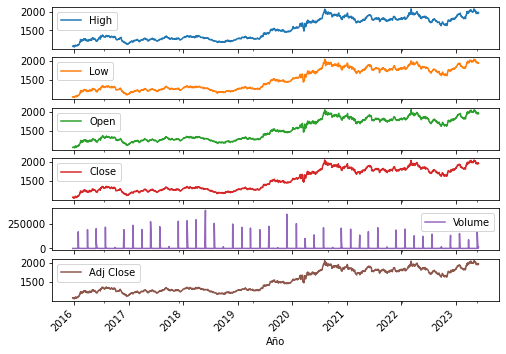

In [5]:
gold.plot(subplots=True, rot=45, xlabel='Año')
plt.show()

## Escalar datos

In [6]:
x = gold.values # Retorna un array de numpy

# Escalador 
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
gold_np_scaled = pd.DataFrame(x_scaled)

## Ajustar los datos

In [7]:
# Necesitamos que la muestra esté en la forma (muestra, tamaño de ventana, número de canales)

samples = 10 # Número de muestras en el pasado (ventana)
steps = 1 # Número de pasos a predecir en el futuro
X = [] # X array
Y = [] # Y array

for i in range(gold_np_scaled.shape[0] - samples):
    X.append(gold_np_scaled.iloc[i:i+samples, 0:5].values) # Muestras independientes
    Y.append(gold_np_scaled.iloc[i+samples, 5:].values) # Muestra dependiente (índice de Adj Close)
print('Datos para entrenamiento: Su tamaño es',len(X[0:1][0]),': ', X[0:1])
print('Dato objetivo: Su tamaño es', len(Y[0:1]),': ', Y[0:1])

Datos para entrenamiento: Su tamaño es 10 :  [array([[1.97029945e-02, 1.19204801e-02, 8.36939210e-03, 2.19891550e-02,
        6.72992799e-05],
       [1.64356194e-02, 1.55884349e-02, 1.68397196e-02, 1.48275902e-02,
        2.74373987e-04],
       [1.26733157e-02, 1.11054757e-02, 1.27054297e-02, 9.38072282e-03,
        5.22863636e-04],
       [1.56436127e-02, 1.52827305e-02, 1.25038051e-02, 1.72483106e-02,
        6.21224122e-05],
       [3.64356919e-02, 1.22261844e-02, 1.61339103e-02, 1.04902402e-02,
        9.34424617e-04],
       [1.75247041e-02, 1.93581253e-02, 1.73439043e-02, 1.75509623e-02,
        6.52285328e-04],
       [8.11876354e-03, 1.22256869e-03, 6.75602569e-03, 0.00000000e+00,
        1.83778803e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.01808793e-04,
        2.58843384e-05],
       [2.02970297e-02, 4.78853915e-03, 1.51255409e-03, 1.51301187e-02,
        3.70146039e-04],
       [1.93069307e-02, 1.71167079e-02, 1.38146114e-02, 1.84587940e-02,
        2

In [8]:
# Debemos hacer un reshape de los inputs para que el modelo los acepte
X = np.array(X)
Y = np.array(Y)
print('Dimensión de X', X.shape, '\nDimensión de Y', Y.shape)

Dimensión de X (1865, 10, 5) 
Dimensión de Y (1865, 1)


## Conjunto de entrenamiento y prueba

In [9]:
threshold = round(0.9 * X.shape[0])  # "Training split" (90-10)

# Conjunto de entrenamiento y de prueba
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]

# Ver las dimensiones
print('Training Length',trainX.shape, trainY.shape,'\nTesting Length:',testX.shape, testY.shape)

Training Length (1678, 10, 5) (1678, 1) 
Testing Length: (187, 10, 5) (187, 1)


# Modelo de predicción un paso adelante

### 1. RNN

In [10]:
# Construiremos la RNN a través de Sequential
model_RNN = keras.Sequential()

# Añadimos una capa tipo RNN con 30 nodos
model_RNN.add(layers.SimpleRNN(30,
                           activation = 'tanh',
                           use_bias=True,
                           input_shape=(trainX.shape[1], trainX.shape[2])))

# Añadimos una capa "dropout" que penalice modelos más complejos -> prevenga overfitting y generalice mejor
model_RNN.add(layers.Dropout(rate=0.2))  # 20% de las neuronas se apagan

# Añadir un perceptrón con un nodo de salida (porque estamos haciendo una regresión)
model_RNN.add(layers.Dense(1))

# La función de pérdida va a ser el MSE, minimizada a través del optimizador adam
model_RNN.compile(loss='mean_squared_error', optimizer = 'adam')

# Ver la arquitectura del modelo
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30)                1080      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 1,111
Trainable params: 1,111
Non-trainable params: 0
_________________________________________________________________


### 2. LSTM

In [11]:
# Construir un modelo LSTM 
model_LSTM = keras.Sequential()

# Capa LSTM con 32 nodos
model_LSTM.add(layers.LSTM(32,
                           activation = "tanh",
                           recurrent_activation = "sigmoid",
                           input_shape=(trainX.shape[1], trainX.shape[2])
                          ))

# Añadimos una capa "dropout" que penalice modelos más complejos -> prevenga overfitting y generalice mejor
model_LSTM.add(layers.Dropout(rate=0.2))


# Añadir un perceptrón con un nodo de salida (porque estamos haciendo una regresión)
model_LSTM.add(layers.Dense(1))

# Evaluar la función de pérdida MSE usando el optimizador "adam"
model_LSTM.compile(loss='mean_squared_error', optimizer = 'adam')

# Arquitectura
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


## Entrenar modelos

In [12]:
# Ajustar los datos al modelo 1
history_RNN = model_RNN.fit(trainX,
                            trainY,
                            shuffle = False, # Para no perder la estructura de autocorrelación temporal
                            epochs=100,
                            batch_size=32,
                            validation_split=0.2,
                            verbose=1) # Ver el avance

# Ajustar los datos al modelo 2
history_LSTM = model_LSTM.fit(trainX,
                            trainY,
                            shuffle = False, # Para no perder la estructura de autocorrelación temporal
                            epochs=100,
                            batch_size=32,
                            validation_split=0.2,
                            verbose=1) # Ver el avance

Epoch 1/100
42/42 [==============================] - 2s 10ms/step - loss: 0.0294 - val_loss: 0.0028
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.0056
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0034
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0069 - val_loss: 0.0019
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 6.7426e-04
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 8/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 9/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 10/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0011
Epoc

42/42 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 8.2485e-04
Epoch 82/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 83/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 5.9417e-04
Epoch 84/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 6.5285e-04
Epoch 85/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 4.9057e-04
Epoch 86/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 6.5639e-04
Epoch 87/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 3.3243e-04
Epoch 88/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 7.4614e-04
Epoch 89/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 7.8599e-04
Epoch 90/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0011 

42/42 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 8.3595e-04
Epoch 62/100
42/42 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 8.1284e-04
Epoch 63/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 5.6133e-04
Epoch 64/100
42/42 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 6.9518e-04
Epoch 65/100
42/42 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 6.7235e-04
Epoch 66/100
42/42 [==============================] - 0s 10ms/step - loss: 9.4847e-04 - val_loss: 4.9736e-04
Epoch 67/100
42/42 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 4.2198e-04
Epoch 68/100
42/42 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 5.7171e-04
Epoch 69/100
42/42 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 5.4034e-04
Epoch 70/100
42/42 [==============================] - 0s 10ms/ste

## Predicción (a un paso)

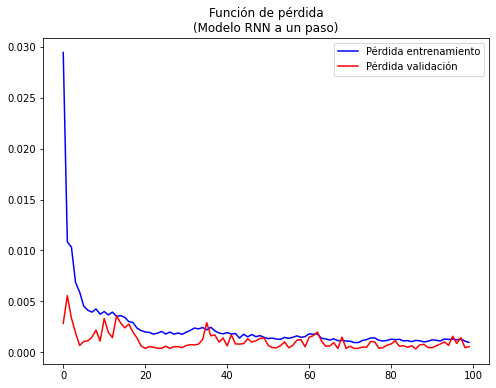

In [13]:
aux.plot_train_history(history_RNN,
                       'Función de pérdida\n(Modelo RNN a un paso)')

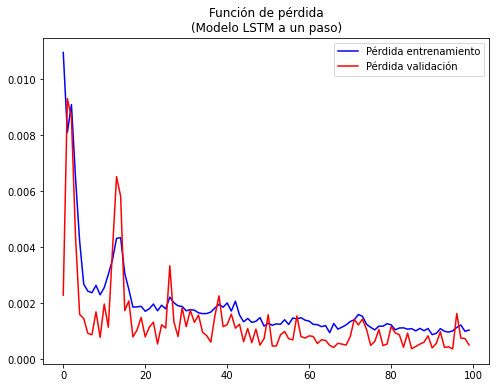

In [14]:
aux.plot_train_history(history_LSTM,
                       'Función de pérdida\n(Modelo LSTM a un paso)')

6/6 [==============================] - 0s 3ms/step


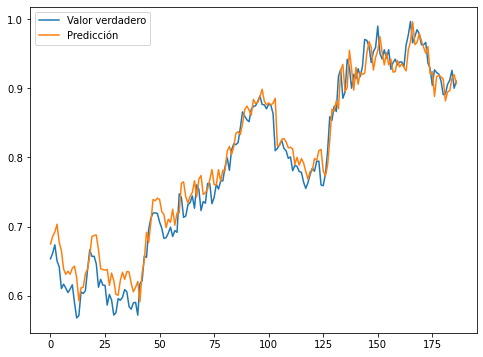

In [15]:
# Predicción un paso adelante
y_pred = model_RNN.predict(testX)
plt.plot(testY, label = 'Valor verdadero')
plt.plot(y_pred, label = 'Predicción')
plt.legend()

6/6 [==============================] - 1s 3ms/step


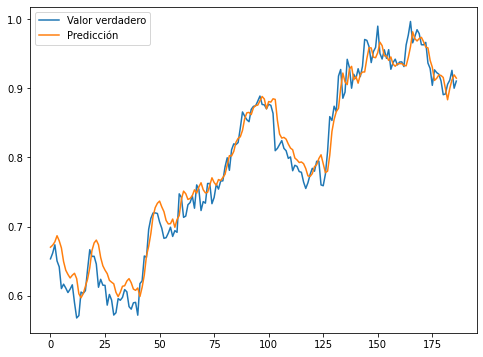

In [16]:
# Predicción un paso adelante
y_pred = model_LSTM.predict(testX)
plt.plot(testY, label = 'Valor verdadero')
plt.plot(y_pred, label = 'Predicción')
plt.legend()

# Modelo de predicción múltiples pasos adelante

In [17]:
dataset = gold.values

TRAIN_SPLIT = int(len(dataset)*0.9 - 1)  # Threshold

data_mean = dataset[:TRAIN_SPLIT].mean(axis = 0)
data_std = dataset[:TRAIN_SPLIT].std(axis = 0)
dataset = (dataset - data_mean)/data_std

In [18]:
# Datos escalados en formato numpy array
dataset = x_scaled

past_history = 60  # Ventana de 60 observaciones pasadas (2 meses)
future_target = 5  # 5 pasos adelante
STEP = 1

x_train_multi, y_train_multi = aux.multivariate_data(dataset,       # Conjunto de entrada
                                                     dataset[:, 5], # Target
                                                     0,             # Índice inicial
                                                     TRAIN_SPLIT,   # Threshold
                                                     past_history,  # Cuántas observaciones pasadas
                                                     future_target, # Dentro de cuántas observaciones futuras pronosticar
                                                     STEP,          # Uno
                                                     single_step = True  # Sólo un valor
                                                    )
x_val_multi, y_val_multi = aux.multivariate_data(dataset,        # Todas las covariables
                                                 dataset[:, 5],  # Var objetivo
                                                 TRAIN_SPLIT,    # Empieza donde terminó training
                                                 None,           # Sigue hasta el final
                                                 past_history,
                                                 future_target,
                                                 STEP,
                                                 single_step = True)

In [19]:
print(x_train_multi.shape, "\n")

print ('Tamaño de una ventana de observaciones pasadas : {}'.format(x_train_multi[0].shape))

(1626, 60, 6) 

Tamaño de una ventana de observaciones pasadas : (60, 6)


In [20]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [21]:
# Construiremos la RNN a través de Sequential
multi_step_model = keras.Sequential()

# Añadimos una capa tipo RNN con 30 nodos
multi_step_model.add(layers.SimpleRNN(30,
                                      activation = 'tanh',
                                      use_bias=True,
                                      input_shape= x_train_multi.shape[-2:]
                              ))

# Añadimos una capa "dropout" que penalice modelos más complejos -> prevenga overfitting y generalice mejor
multi_step_model.add(layers.Dropout(rate=0.2))  # 20% de las neuronas se apagan

# Añadir un perceptrón con un nodo por cada paso adelante (porque estamos haciendo una regresión)
multi_step_model.add(layers.Dense(1))

# La función de pérdida va a ser el MSE, minimizada a través del optimizador adam
multi_step_model.compile(loss='mean_squared_error', optimizer = 'adam')

# Ver la arquitectura del modelo
multi_step_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 30)                1110      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


In [22]:
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs = 100,
                                          steps_per_epoch = 40,
                                          validation_data = val_data_multi,
                                          validation_steps = 50)

Epoch 1/100
40/40 [==============================] - 3s 28ms/step - loss: 0.1119 - val_loss: 0.0077
Epoch 2/100
40/40 [==============================] - 1s 23ms/step - loss: 0.0331 - val_loss: 0.0044
Epoch 3/100
40/40 [==============================] - 1s 22ms/step - loss: 0.0225 - val_loss: 0.0094
Epoch 4/100
40/40 [==============================] - 1s 21ms/step - loss: 0.0208 - val_loss: 0.0055
Epoch 5/100
40/40 [==============================] - 1s 22ms/step - loss: 0.0163 - val_loss: 0.0096
Epoch 6/100
40/40 [==============================] - 1s 20ms/step - loss: 0.0132 - val_loss: 0.0050
Epoch 7/100
40/40 [==============================] - 1s 17ms/step - loss: 0.0122 - val_loss: 0.0042
Epoch 8/100
40/40 [==============================] - 1s 21ms/step - loss: 0.0100 - val_loss: 0.0030
Epoch 9/100
40/40 [==============================] - 1s 18ms/step - loss: 0.0106 - val_loss: 0.0024
Epoch 10/100
40/40 [==============================] - 1s 18ms/step - loss: 0.0092 - val_loss: 0.0024

40/40 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 83/100
40/40 [==============================] - 1s 18ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 84/100
40/40 [==============================] - 1s 20ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 85/100
40/40 [==============================] - 1s 21ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 86/100
40/40 [==============================] - 1s 20ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 87/100
40/40 [==============================] - 1s 19ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 88/100
40/40 [==============================] - 1s 21ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 89/100
40/40 [==============================] - 1s 22ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 90/100
40/40 [==============================] - 1s 18ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 91/100
40/40 [==============================] - 1s 20ms/step - loss: 0.0020 - val_loss: 0.0040
Epo

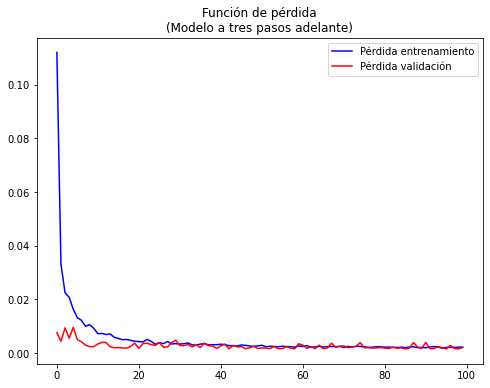

In [23]:
aux.plot_train_history(multi_step_history,
                       'Función de pérdida\n(Modelo a tres pasos adelante)')

In [24]:
y_predictions = multi_step_model.predict(x_val_multi)

4/4 [==============================] - 0s 5ms/step


In [25]:
y_pred_orig = min_max_scaler.inverse_transform(np.repeat(y_predictions, 6, axis = 1))[:,5]
y_true_orig = min_max_scaler.inverse_transform(np.repeat(np.resize(y_val_multi,(len(y_val_multi),1)),6, axis = 1))[:,5]

In [26]:
def RMS(actual, predicted):
    return np.sqrt(np.mean(np.power(predicted-actual,2)))

print("RMS - Medida del error de predicción\n------------------------------------")
print("Escala original:", round(RMS(y_pred_orig, y_true_orig),3))
print("Sin revertir la escala:", round(RMS(y_predictions, y_val_multi),3))

RMS - Medida del error de predicción
------------------------------------
Escala original: 45.216
Sin revertir la escala: 0.11


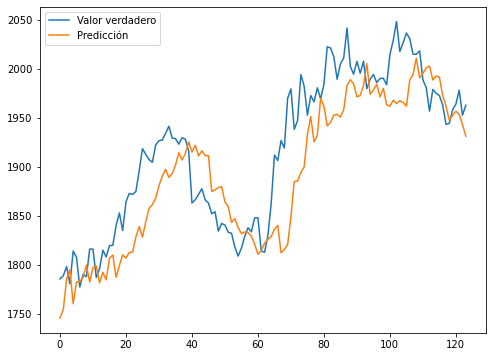

In [27]:
plt.plot(y_true_orig, label = 'Valor verdadero')
plt.plot(y_pred_orig, label = 'Predicción')
plt.legend()

1/1 [==============================] - 0s 357ms/step


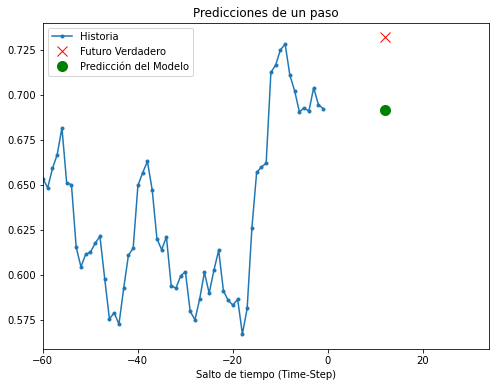

1/1 [==============================] - 0s 61ms/step


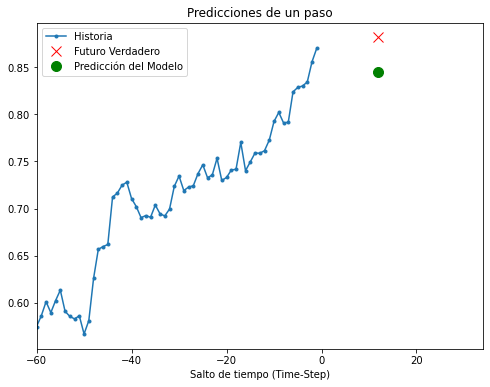

1/1 [==============================] - 0s 77ms/step


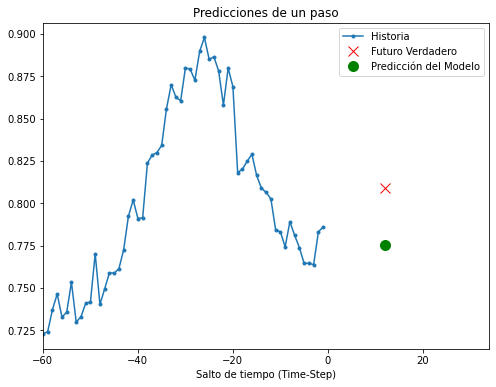

In [28]:
for x, y in val_data_multi.take(3):
    plot = aux.show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    multi_step_model.predict(x)[0]], 12,
                   'Predicciones de un paso')
    plot.show()

## Intervalos de predicción: Método 1

In [29]:
from sklearn.metrics import mean_absolute_error
def fit_model(x_train_multi, y_train_multi):
    model = keras.Sequential()
    model.add(layers.SimpleRNN(30,
                               activation = 'tanh',
                               use_bias=True,
                               input_shape= x_train_multi.shape[-2:]
                              ))
    model.add(layers.Dropout(rate=0.2)) 
    model.add(layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer = 'adam')
    model.fit(train_data_multi,
              epochs = 100,
              steps_per_epoch = 40,
              validation_data = val_data_multi,
              validation_steps = 50,
              verbose=0)
    return model

In [30]:
def fit_ensemble(n_members, x_train_multi, x_val_multi, y_train_multi, y_val_multi):
    ensemble = list()
    for i in range(n_members):
        # Definir y entrenar el modelo en el conjunto de entrenamiento
        model = fit_model(x_train_multi, y_train_multi)
        # Evaluar el modelo en el conjunto de testeo
        yhat = model.predict(x_val_multi, verbose=0)
        mae = mean_absolute_error(y_val_multi, yhat)
        print('>%d, MAE: %.3f' % (i+1, mae))
        # Guardar el modelo
        ensemble.append(model)
    return ensemble

In [31]:
def predict_with_pred_int(ensemble, X):
    # Hacer prediccciones
    yhat = [model.predict(X, verbose=0) for model in ensemble]
    yhat = np.asarray(yhat)
    # Calcular un intervalo del 95% (Asumiendo que es un proceso gaussiano)
    interval = 1.96 * yhat.std()
    lower, upper = yhat.mean() - interval, yhat.mean() + interval
    return lower, yhat.mean(), upper

In [32]:
n_members = 30
ensemble = fit_ensemble(n_members, x_train_multi, x_val_multi, y_train_multi, y_val_multi)

>1, MAE: 0.032
>2, MAE: 0.040
>3, MAE: 0.034
>4, MAE: 0.036
>5, MAE: 0.032
>6, MAE: 0.042
>7, MAE: 0.031
>8, MAE: 0.055
>9, MAE: 0.031
>10, MAE: 0.032
>11, MAE: 0.043
>12, MAE: 0.033
>13, MAE: 0.036
>14, MAE: 0.031
>15, MAE: 0.034
>16, MAE: 0.043
>17, MAE: 0.034
>18, MAE: 0.033
>19, MAE: 0.051
>20, MAE: 0.032
>21, MAE: 0.032
>22, MAE: 0.032
>23, MAE: 0.035
>24, MAE: 0.037
>25, MAE: 0.046
>26, MAE: 0.034
>27, MAE: 0.034
>28, MAE: 0.031
>29, MAE: 0.036
>30, MAE: 0.048


In [33]:
newX = np.asarray([x_val_multi[2, :]])
lower, mean, upper = predict_with_pred_int(ensemble, newX)
print('Point prediction: %.3f' % mean)
print('95%% prediction interval: [%.3f, %.3f]' % (lower, upper))
print('True value: %.3f' % y_val_multi[2])
print('True value: %.3f' % y_predictions[2])

Point prediction: 0.725
95% prediction interval: [0.700, 0.749]
True value: 0.744
True value: 0.732


In [34]:
lower_list, mean_list, upper_list = [], [], []
for i in range(0,y_val_multi.shape[0]):
    newX = np.asarray([x_val_multi[i, :]])
    lower, mean, upper = predict_with_pred_int(ensemble, newX)
    lower_list.append(lower)
    mean_list.append(mean)
    upper_list.append(upper)

In [41]:
len(y_predictions)

124

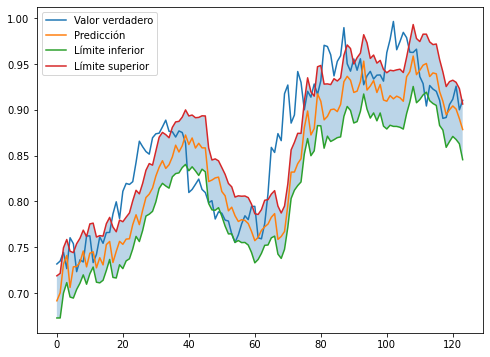

In [43]:
plt.plot(y_val_multi, label = 'Valor verdadero')
plt.plot(y_predictions, label = 'Predicción')
plt.plot(lower_list, label = 'Límite inferior')
plt.plot(upper_list, label = 'Límite superior')
plt.fill_between(range(0,124), lower_list, upper_list, alpha = 0.3)
plt.legend()

In [44]:
cobertura_pred = [True if (lower_list[i] <=y_predictions[i] <= upper_list[i]) else False for i in range(0, len(y_predictions))]
cobertura_orig = [True if (lower_list[i] <=y_val_multi[i] <= upper_list[i]) else False for i in range(0, len(y_predictions))]
print("Porcentaje de las predicciones que caen dentro del intervalo:", round(sum(cobertura_pred)*100/len(cobertura_pred),2), "%")
print("Porcentaje de las predicciones que caen dentro del intervalo:", round(sum(cobertura_orig)*100/len(cobertura_orig),2), "%")

Porcentaje de las predicciones que caen dentro del intervalo: 100.0 %
Porcentaje de las predicciones que caen dentro del intervalo: 49.19 %
